In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time
from cycler import cycler

## Deeper (and Wider) GCNs

So our results in Section 2.1 obviously beget the question: can we do better? We don't want a model that is actively worse at learning structure for a large (and arguably quite common) class of networks; at the very least, we would like to minimize the difference in performance between high and low-density networks, which we term the *topological performance gap*. Going back to one of our definitions for $d_{Katz}$, 

$$d_{Katz} = \sum_{k=0}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

it seems fairly obvious that a larger $l_{max}$ should lead to a closer approximation of the first term. To verify this, we train an $m=16$ GraphConv model for all $l_{max}=4,8,16,..,64$ and report convergence. We also train a set of $l_{max}=4$ models while varying $m$ from $4$ to $256$, which allows us to assess the impact of an increased parameter count without any associated change in the number of convolutions. Since EdgeConv did not seem to offer any noticable benefit before, we exclude it from these experiments. We also now train with an $\eta{}$ of $1e^{-3}$, as it offers better stability for larger models.

In [59]:
torch.manual_seed(0)

num_graphs = 250
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    _,vecs = torch.eig(adj.to_dense(),eigenvectors=True)
    
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:200],d[200::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

In [3]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Global Feature Similarity
def batched_GFS(X,edge_index,edge_weights,batch):
    X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
    
    GFS = 0
    for idx,batch_idx in enumerate(batch.unique()):
        cosine = torch.clip(1 - torch.matmul(X[batch==batch_idx].T,X[batch==batch_idx]).abs(),0,1)
        GFS += cosine.sum()/(cosine.shape[0]*(cosine.shape[0]-1))
    
    return GFS/(idx+1)
# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [4]:
base_R = 0
for idx,data in enumerate(test_loader):
    base_R += rayleigh_quotient(data.y.cuda()[:,None],data.edge_index.cuda(),data.edge_weight.cuda(),
                                    data.batch.cuda(),data.eig_max.cuda(),data.eig_min.cuda()).item()
base_R/=(idx+1)

### Width Testing

In [18]:
graph_results = []
for k in [4,8,16,32,64,128,256]:
    torch.manual_seed(0)
    graph = GraphConv(1,k,1,4).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,100,lr=1e-3))

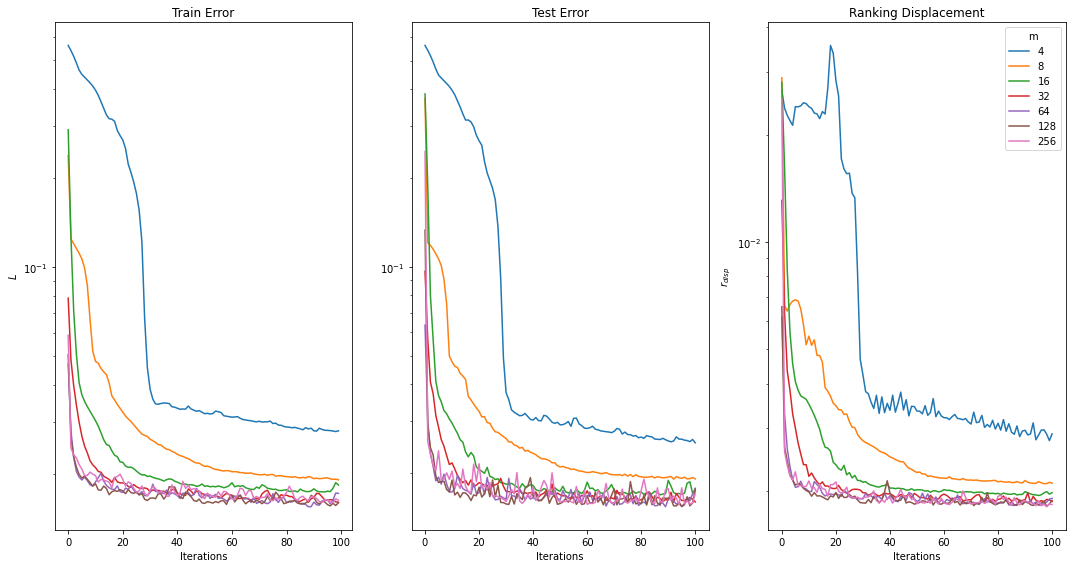

In [19]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([4,8,16,32,64,128,256]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='m')

plt.tight_layout();

Above, we plot a) training loss b) test loss and c) average rank displacement for the $l_{max}=4$ model as width $m$ goes from $4$ to $128$. The figure below shows the best values on the train and test loss over the last 10 epochs versus $m$. 

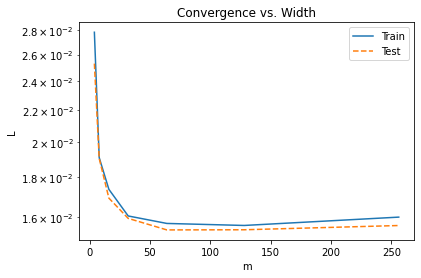

In [20]:
params = [4,8,16,32,64,128,256]
plt.semilogy(params,[np.min(graph_results[i][0][-10::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.min(graph_results[i][1][-10::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('m')
plt.ylabel('L');
plt.title('Convergence vs. Width');

Our model's performance does not depend strongly on width for $m\geq{}4$. Despite some initial benefit, increasing $m$ is subject to diminishing returns, and the loss completely stagnates past $m=32$. Whatever is causing the topological performance gap, it cannot be solved simply by adding more parameters.

### Depth Testing

In [21]:
graph_results = []
metrics = []
for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = GraphConv(1,16,1,k).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,300,lr=1e-3))
    torch.save(graph.state_dict(),'base_{}'.format(k))

    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        
        for jdx,m in enumerate(graph.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
            
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                    batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
    metrics.append([MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)])
    torch.cuda.empty_cache()

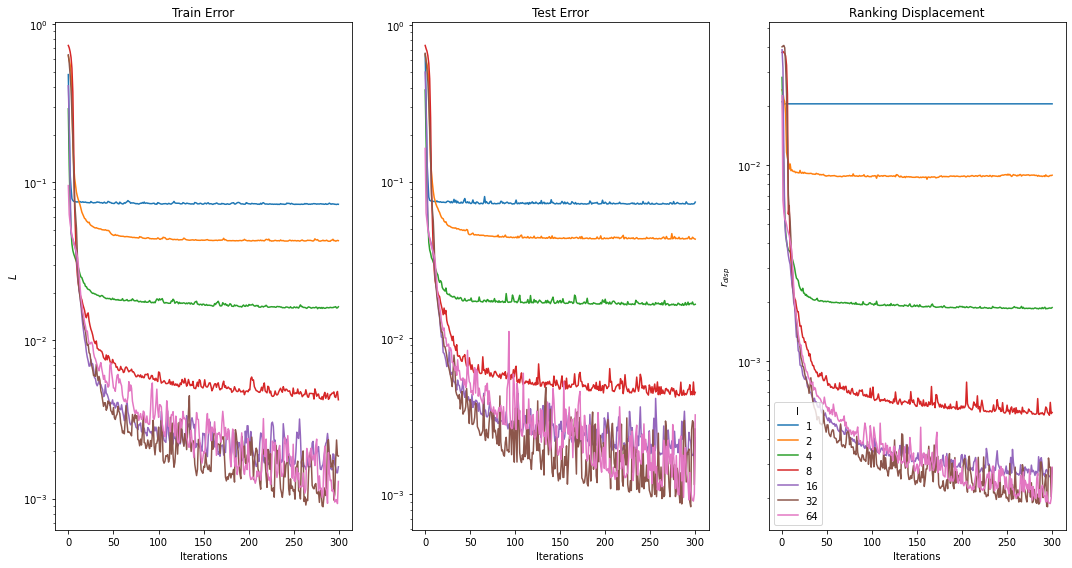

In [22]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='l')

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for the $m=16$ model with $l_{max}=1,2,4,...,64$. The figure below shows the best values on the train and test loss over the last 10 epochs versus $l_{max}$. 

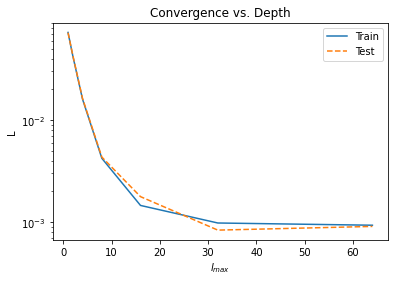

In [23]:
params = [1,2,4,8,16,32,64]
plt.semilogy(params,[np.min(graph_results[i][0][-10::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.min(graph_results[i][1][-10::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('$l_{max}$')
plt.ylabel('L');
plt.title('Convergence vs. Depth');

Increasing GCN depth leads to some improvement, and all our models surpass their corresponding $q=l_{max}$ truncated sum approximations (see Section 2.1). However, we have only just hit the $10^{-3}$ mark, and both the train and test loss flatten out with respect to depth for $l_{max}>32$. We suspect GraphConv is either a) having difficulty backpropagating due to the greater model depth or b) running into convergence problems with the increased number of convolutions.

### Some Analysis

#### Adding Residual Connections

To assess whether network depth is having adverse effects on backpropagation, we train an $l_{max}=64$ GraphConv model with 1-hop residual connections following each non-linearity. If there is truly an issue, then we should expect to see improvement over the non-residual model.

In [24]:
class ResidualGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(ResidualGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            nX = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = X + torch.nn.LeakyReLU()(nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch])
            
        # Project to out_channels
        return self.finish(X)

In [25]:
residual_results = []

torch.manual_seed(0)
graph = ResidualGraphConv(1,16,1,64).cuda()

residual_results.append(train_loop(graph,train_loader,test_loader,300,lr=1e-3))
torch.save(residual_results,'residual_results{}'.format(32))
torch.cuda.empty_cache()

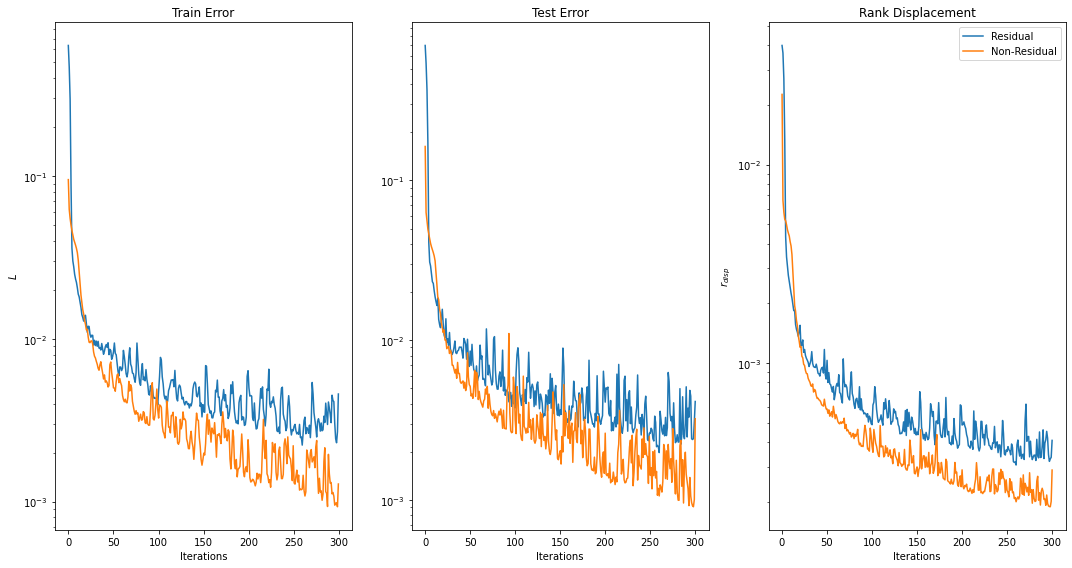

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(residual_results[0][0])
plt.semilogy(graph_results[-1][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(residual_results[0][1])
plt.semilogy(graph_results[-1][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(residual_results[0][2],label='Residual')
plt.semilogy(graph_results[-1][2],label='Non-Residual')

plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Adding residual connections actually appears to slightly hampen convergence. This contradicts the notion that our deeper models are underperforming due to backpropgation issues.

#### Evaluating the Number of Convolutions

Wu et. al. (2019) introduced the Simplified Graph Convolution (SGC) [17]

$$X^{out} = \Theta{}(A^{l_{max}}X^{in})$$

In practice, they found that removing the non-linearities at each GCN layer did not affect classification accuracy whilst greatly reducing training time and maintaining a constant number of parameters. We follow the example of [16] (and others) and use SGC to estimate the impact of a greater number of convolutions independent of parameter count. We train for $l_{max}=4,8,16,...,64$. $\Theta$ is a four-layer MLP of intermediate dimension $R^{32}$ with BatchNorm and LeakyReLU nonlinearity. $A^{l_{max}}X^{in}$ is computed through succesive matrix-matrix products; for the sake of stability, we normalize the columns at each iteration. We train for 20 epochs with $\eta{}=1e^{-3}$.

In [21]:
class SGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(SGC,self).__init__()

        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        for _ in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        return self.finish(X)

In [22]:
sgc_results = []
metrics = []

for k in [4,8,16,32,64]:
    torch.manual_seed(0)
    model = SGC(1,32,1,k).cuda()

    sgc_results.append(train_loop(model,train_loader,test_loader,20,lr=1e-3))

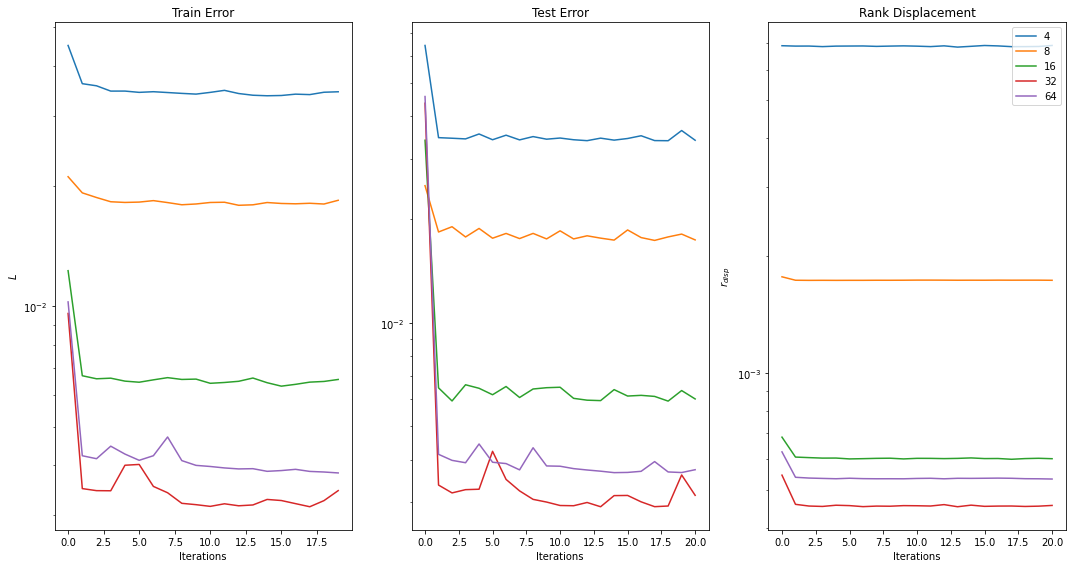

In [23]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][0])
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([4,8,16,32,64]):
    plt.semilogy(sgc_results[idx][2],label=k)
plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout()

plt.show()

Like GraphConv, the loss of SGC worsens from $l_{max}=32$ to $l_{max}=64$. This indicates that the additional convolutions, instead of improving performance, are causing it to degrade past a certain model depth.

### GCN Smoothing and Normalization

And this leads us nicely into a pet topic of mine. While SGC is an oversimplified case, GCNs more generally do suffer from a peculiar phenomena known as *oversmoothing*. In essence, as you add more layers, the features of each node converge to fixed values. Current theoretical analysis of oversmoothing has been focused on the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (\hat{D}^{\frac{-1}{2}}\hat{A}\hat{D}^{\frac{-1}{2}})X^{l}W$$
$$ \hat{A} = I + A \; \; \; \; \hat{D} = \hat{A}\vec{1}$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{-1}{2}}$. By definition, $L_{sym}$ possesses eigenvalues $0\leq{}\lambda_{i}\leq{}2$. We are  guaranteed an eigenvector $v_{i}=D^{\frac{1}{2}}\vec{1}$ for $i$ such that $\lambda_{i}=0$, and dropping $I$ shifts the eigenvalue spectra, making $v_{i}$ dominant. The asymptoptic behavior of the GCNConv aggregation step is to therefore diffuse material until it is distributed according to the square root of the augmented node degree $\hat{D}$. Since most real-life networks possess approximately power-law degree distributions, the majority of nodes will eventually become indistinguishable; this is the root of the oversmoothing problem in GCNConv. However, the literature demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable [14,16] to oversmoothing. As an example, we train our GraphConv model (both with and without any normalization) on the Cora node classification benchmark and report on the smoothness of its intermediate representations. We choose to measure this by the sparsified Mean Average Distance (MAD) [14],

$$MAD(X^{l},E,V) = \frac{1}{|V|}\sum_{i\in{V}}(\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{|(x_{j}^{l})^{T}x^{l}_{i}|}{||x^{l}_{i}||_{2}||x^{l}_{j}||_{2}}))$$

Global Feature Similarity (or GFS),

$$GFS(X^{l},E,V) = \frac{2}{m(m-1)}\sum_{i=0}^{m}\sum_{j=i+1}^{m}(1 - \frac{|(X_{:,i}^{l})^{T}X_{:,j}^{l}|}{||X^{l}_{:,i}||_{2}||X^{l}_{:,j}||_{2}})$$

and the absolute Rayleigh Quotient,

$$R(X^{l},A,V) = \frac{1}{|V|}\sum_{i\in{}V}(\frac{1}{\lambda_{max}-\lambda_{min}}(\lambda_{max} - |\frac{\vec{x}^{l}_{i}A\vec{x}^{l}_{i}}{\vec{x}^{l}_{i}\cdot{}\vec{x}^{l}_{i}}|))$$

with MinMax normalization. $\lambda_{max}$ and $\lambda_{min}$ are the eigenvalues of $A$ with, respectively, the largest and smallest absolute values. MAD quantifies the similarity of adjacent nodes, whereas GFS measures how close the columns $X_{:,i}^{l}$ are to one another. Both employ the cosine distance for scale invariance. The normalized Rayleigh Quotient reflects how close each column is to the dominant eigenvector $v_{1}$, with $R(X^{l})=0$ indicating they are equivalent. 

In [10]:
def citeseer_train_loop(model,data,epochs,lr=1e-3):
    train_loss = []
    test_loss = []

    try: opt = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
    except: pass;
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    model.eval()
    with torch.no_grad():
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)
        test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    for epoch in range(epochs):
        model.train()
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)

        loss = torch.nn.CrossEntropyLoss()(preds[data.train_mask],Y[data.train_mask])
        train_loss.append(torch.mean((preds[data.train_mask].argmax(dim=1)==Y[data.train_mask]).float()))

        loss.backward()
        opt.step()
        opt.zero_grad()

            
        model.eval()
        with torch.no_grad():
            X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
            batch = data.batch.cuda()

            preds = model(X,edge_index,edge_weight,batch)
            test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    return train_loss,test_loss

In [18]:
citeseer = torch_geometric.datasets.Planetoid('.','Cora',split="full")[0]
citeseer.edge_index = torch_geometric.utils.to_undirected(citeseer.edge_index)
citeseer.x = citeseer.x/(1e-4 + torch.norm(citeseer.x,dim=1))[:,None]

citeseer.edge_weight = torch.ones((citeseer.edge_index.shape[1]))
citeseer.batch = torch.zeros((citeseer.x.shape[0])).long()
val = torch.eig(torch_sparse.SparseTensor(row=citeseer.edge_index[0],col=citeseer.edge_index[1],
                                          value=citeseer.edge_weight).to_dense())[0]
val = torch.norm(val,dim=1)
citeseer.eig_min = val.min() * torch.ones((1))
citeseer.eig_max = val.max() * torch.ones((1))

In [16]:
citeseer_metrics = []
citeseer_metrics2 = []


for k in [1,2,4,8,16]:
    torch.manual_seed(0)
    model = GraphConv(citeseer.x.shape[-1],16,len(citeseer.y.unique()),k,norm=False).cuda()

    _ = citeseer_train_loop(model,citeseer,200,lr=1e-2)
    
    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    X = citeseer.x.cuda()
    row,col = citeseer.edge_index[0].cuda(),citeseer.edge_index[1].cuda()
    batch = citeseer.batch.cuda()

    model.eval()
    X = model.start(X)
        
    for jdx,m in enumerate(model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X)
        
        MAD[jdx] += batched_MAD(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),
                                batch,citeseer.eig_max.cuda(),citeseer.eig_min.cuda()).item()
            
    citeseer_metrics.append([MAD,GFS,Ray])
    
    torch.manual_seed(0)
    model = GraphConv(citeseer.x.shape[-1],16,len(citeseer.y.unique()),k,norm=True).cuda()

    _ = citeseer_train_loop(model,citeseer,200,lr=1e-2)
    
    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    X = citeseer.x.cuda()
    row,col = citeseer.edge_index[0].cuda(),citeseer.edge_index[1].cuda()
    batch = citeseer.batch.cuda()

    model.eval()
    X = model.start(X)
        
    for jdx,m in enumerate(model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
        
        MAD[jdx] += batched_MAD(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),
                                batch,citeseer.eig_max.cuda(),citeseer.eig_min.cuda()).item()
            
    citeseer_metrics2.append([MAD,GFS,Ray])
    torch.cuda.empty_cache()

Below we plot the minimum MAD, GFS, and normalized Rayleigh across all layers versues $l_{max}$. We justify looking at the minimum in that, once oversmoothing occurs in any given layer, the network will be unable to recover information regarding the node features. It may happen upon less smooth representations in subsequent layers, sure, but they are going to be independent of the input. 

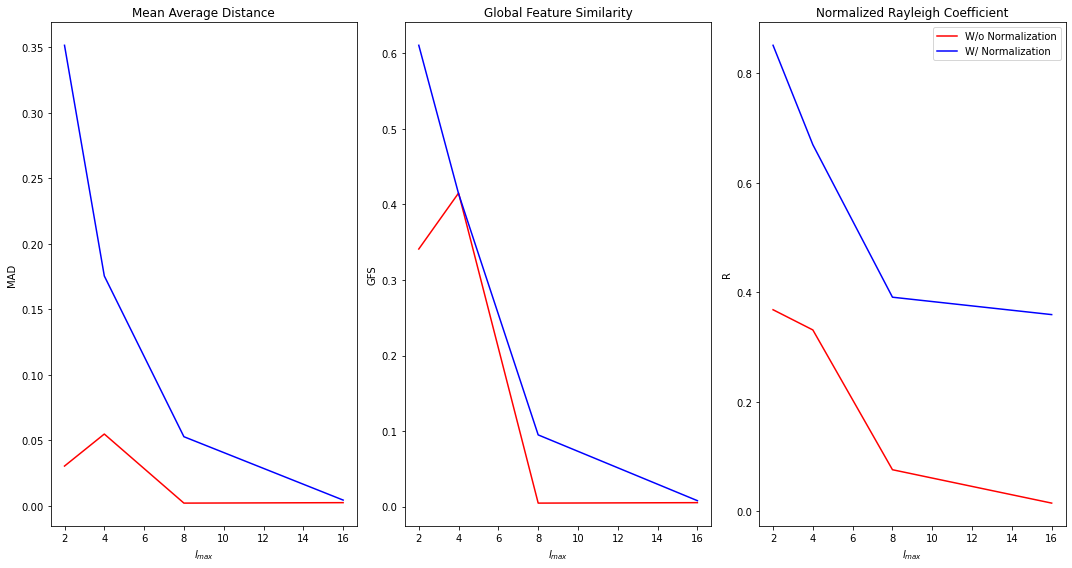

In [17]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    mad.append(citeseer_metrics[idx+1][0].min().item())
    mad2.append(citeseer_metrics2[idx+1][0].min().item())
  plt.plot([2,4,8,16],mad,c='r')
  plt.plot([2,4,8,16],mad2,c='b')
  plt.xlabel('$l_{max}$')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    gfs.append(citeseer_metrics[idx+1][1].min().item())
    gfs2.append(citeseer_metrics2[idx+1][1].min().item())
  plt.plot([2,4,8,16],gfs,c='r')
  plt.plot([2,4,8,16],gfs2,c='b')
  plt.xlabel('$l_{max}$')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    ray.append(citeseer_metrics[idx+1][2].min().item())
    ray2.append(citeseer_metrics2[idx+1][2].min().item())
  plt.plot([2,4,8,16],ray,label='W/o Normalization',c='r')
  plt.plot([2,4,8,16],ray2,label='W/ Normalization',c='b')
  plt.xlabel('$l_{max}$')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Coefficient')
  plt.legend()

  plt.tight_layout()
  plt.show()

As $l_{max}$ increases, we observe the following:

  - The MAD for our normalized model begins at just over $.35$ and decays exponentially towards $0$, which means that adjacent nodes are becoming more homogenous with depth. The unnormalized model is much smaller in terms of MAD for all $l_{max}$, though it too converges to $0$. 
  - Both models start with a fairly large GFS ($.6$ and $.34$, respectively). As they each go to $0$, features become more and more indistinguisable. The normalized model takes longer to decay, only hitting $0$ for $l_{max}=16$, whereas the unnormalized one converges at $l_{max}=8$. 
  - $R$ is the most interesting part of the picture here. While GFS and MAD would suggest that our deepest models are fairly similar with or without normalization (they are equally "smooth", so to speak), the two end up converging to very different values of $R$. The latter finishes at approx. $.03$, so it has basically produced the dominant eigenvector. However, the normalized model bottoms out at $.4$, and each feature is, on average, not remotely close to $v_{1}$. 
  
Now, as far as learning $d_{Katz}$ is concerned, this presents a big issue. We actually want to converge to something close to $v_{1}$, seeing as to the previously stated connection between $d_{Katz}$ and $d_{eig}$. Normalization appears to inhibit this, but, by the same measure, $l_{max}>16$ models can otherwise be quite unstable. Moreover, we cannot know *a prior* whether paramterizing $v_{1}$ would even be beneficial to a given graph learning task, so simply dropping all normalization is not a good reccomendation. 

To this end, we propose a lightwieght, trainable variant of columwise-normalization:

$$X_{i,j}^{l} = \frac{X_{i,j}^{l}}{1 + \sigma{}(\vec{s}_{i})(||X_{:,j}^{l}||_{2} - 1)}$$

where $\vec{s}\in{}R^{n}$. Varying $\vec{s}$ allows the model to interpolate between the fully-normalized and unnormalized cases, in addition further differentiating each particular feature. This scheme addresses all our above concerns; if we don't want to learn $v_{1}$ (or not have feature $i$ converge to it), then simply $\sigma{}(\vec{s}_{i})=1$, and the model can also keep earlier layers normalized to prevent instability.

We repeat our earlier depth experiments with this new normalization scheme. We also retrain an $l_{max}=4, m=16$ model on the high-density dataset and compare its $R$ against those of our various low-density GCNs.

In [53]:
class TrainableColumnNorm(torch.nn.Module):
    def __init__(self,int_channels):
        super(TrainableColumnNorm,self).__init__()
        self.s = torch.nn.Parameter(torch.zeros(int_channels))
    def forward(self,X,batch):
        X_norm = torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        s = torch.sigmoid(self.s)
        
        X = X/(1 + s[None,:] * (X_norm - 1))[batch]
        return X
    
class NormedGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(NormedGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.n = torch.nn.ModuleList([TrainableColumnNorm(int_channels) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = self.n[idx](X,batch)

        # Project to out_channels
        return self.finish(X.abs())

In [57]:
graph_results2 = []
metrics2 = []
for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = NormedGraphConv(1,16,1,k).cuda()
    
    graph_results2.append(train_loop(graph,train_loader,test_loader,10,lr=1))

    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        
        for jdx,m in enumerate(graph.intermediate):
            X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(graph.n[jdx](X,batch))
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                    batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
    metrics2.append([MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)])
    torch.cuda.empty_cache()

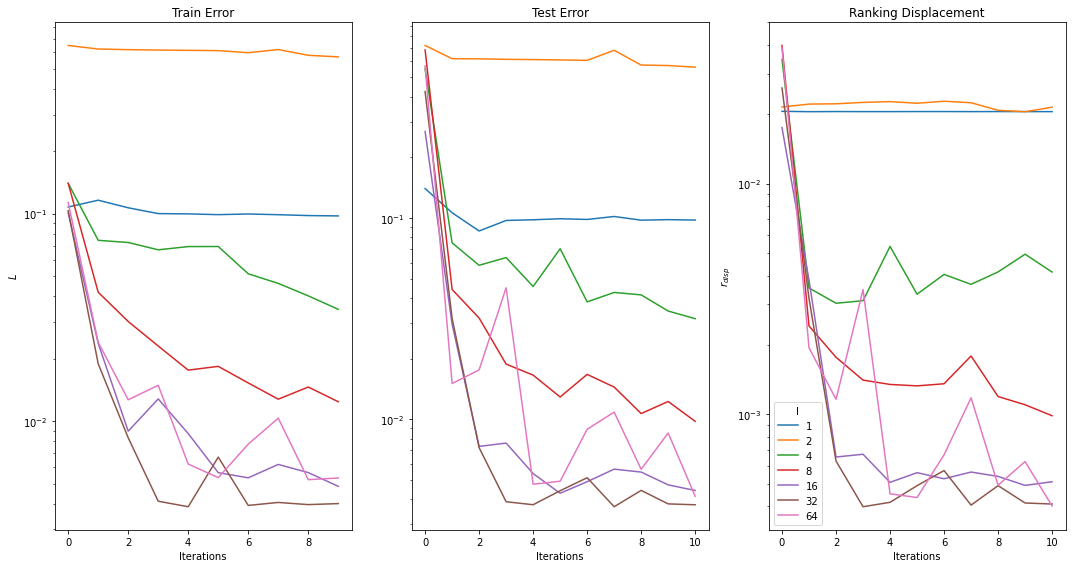

In [58]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results2[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results2[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results2[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='l')

plt.tight_layout();

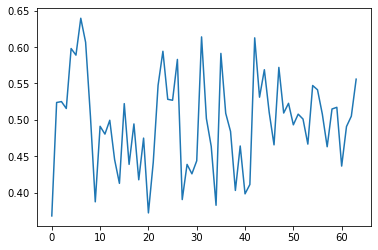

In [52]:
s = []
for l in graph.n:
    s.append(torch.sigmoid(l.s).mean())
plt.plot(s)

In [55]:
torch.manual_seed(0)

num_graphs = 250
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(n) + (9/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:200],d[200::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [56]:
dense_R = 0
for idx,data in enumerate(test_loader):
    dense_R += rayleigh_quotient(data.y.cuda()[:,None],data.edge_index.cuda(),data.edge_weight.cuda(),
                                    data.batch.cuda(),data.eig_max.cuda(),data.eig_min.cuda()).item()
dense_R/=(idx+1)

In [57]:
torch.manual_seed(0)

dense_model = GraphConv(1,16,1,4).cuda()

dense_results = train_loop(dense_model,train_loader,test_loader,50,lr=1e-1)
torch.cuda.empty_cache()
MAD,GFS,Ray = torch.zeros(4),torch.zeros(4),torch.zeros(4)
    
for idx,data in enumerate(test_loader):
    X = data.x.cuda()
    row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
    batch = data.batch.cuda()

    dense_model.eval()
    X = dense_model.start(X)

    for jdx,m in enumerate(dense_model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
        MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
        
    dense_metrics = [MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)]

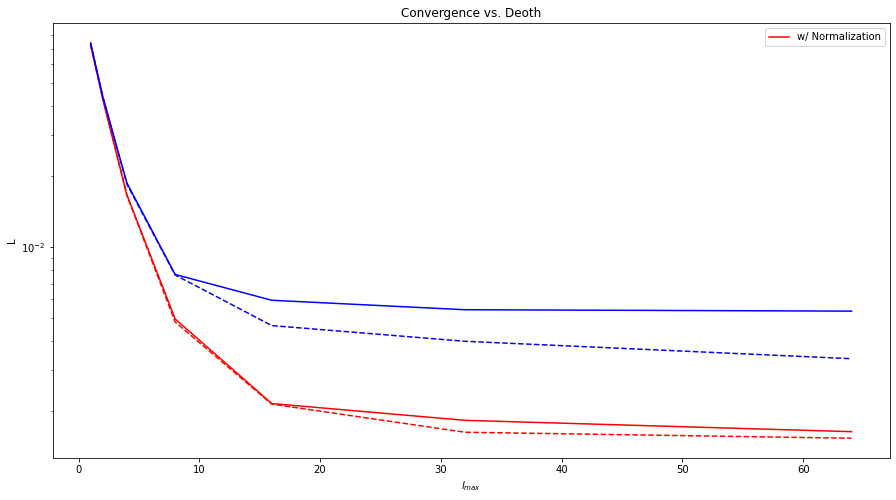

In [59]:
params = [1,2,4,8,16,32,64]
plt.semilogy(params,[np.min(graph_results[i][0][-10::]) for i in range(7)],label='Base Normalization',c='r')
plt.semilogy(params,[np.min(graph_results[i][1][-10::]) for i in range(7)],linestyle='--',c='r')

plt.semilogy(params,[np.min(graph_results2[i][0][-10::]) for i in range(7)],label='Trainable Normalization',c='b')
plt.semilogy(params,[np.min(graph_results2[i][1][-10::]) for i in range(7)],linestyle='--',c='b')
plt.legend();
plt.xlabel('$l_{max}$')
plt.ylabel('L');
plt.title('Convergence vs. Depth');

NameError: name 'metrics' is not defined

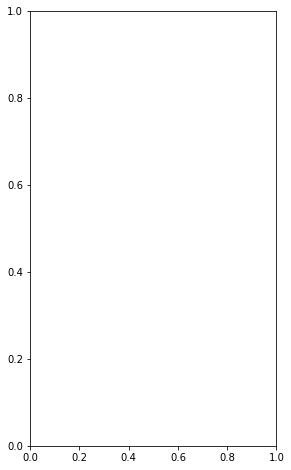

In [19]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    mad.append(metrics[idx+1][0].min().item())
    mad2.append(metrics2[idx+1][0].min().item())
  plt.plot([2,4,8,16],mad,c='r')
  plt.plot([2,4,8,16],mad2,c='b')
  plt.xlabel('$l_{max}$')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    gfs.append(metrics[idx+1][1].min().item())
    gfs2.append(metrics2[idx+1][1].min().item())
  plt.plot([2,4,8,16],gfs,c='r')
  plt.plot([2,4,8,16],gfs2,c='b')
  plt.xlabel('$l_{max}$')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    ray.append(metrics[idx+1][2].min().item())
    ray2.append(metrics2[idx+1][2].min().item())
  plt.plot([2,4,8,16],ray,label='W/o Normalization',c='r')
  plt.plot([2,4,8,16],ray2,label='W/ Normalization',c='b')
  plt.hlines(base_R,2,16)
  plt.xlabel('$l_{max}$')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Coefficient')
  plt.legend()

  plt.tight_layout()
  plt.show()

For the dense dataset, our model converges rapidly to $v_{1}$ with only $l_{max}=4$, as indicated by the small $R$ and GFS. None of the models trained on the low-density data can match this, much less ones of similar depth. And, aside from GFS, their metrics stop meaningfully decreasing past $l_{max}=16$. 

Let us look at how MAD, GFS and $R$ vary layer-by-layer, starting with the high-density model:

There is a consistent decrease in all three metrics as we go through successive GCN layers. MAD and $R$ increase following the third aggregation, but GFS still continues to decline, albeit at a slower rate. The minimum values are located at or near the final layer. This is quite a different picture to the low-density model:

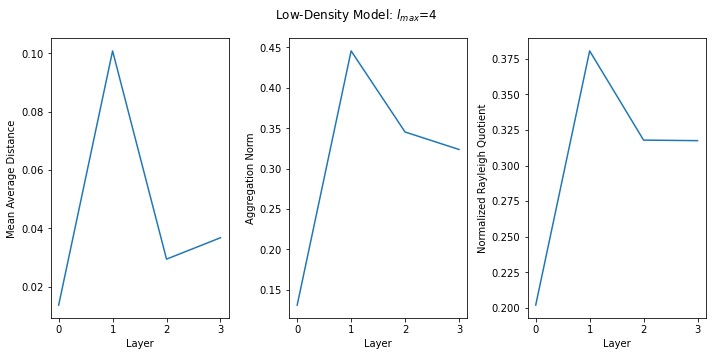

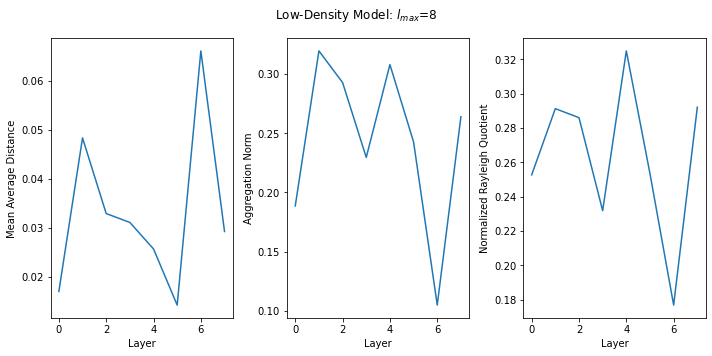

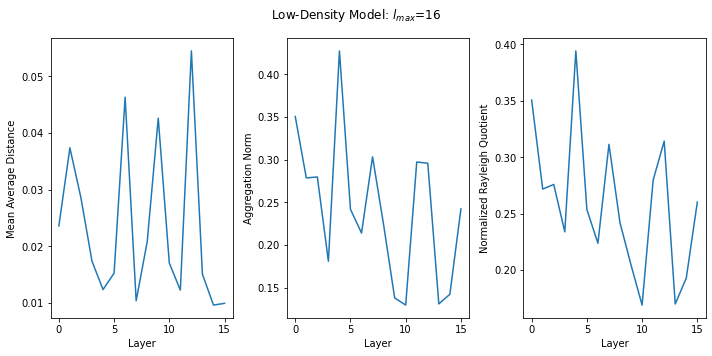

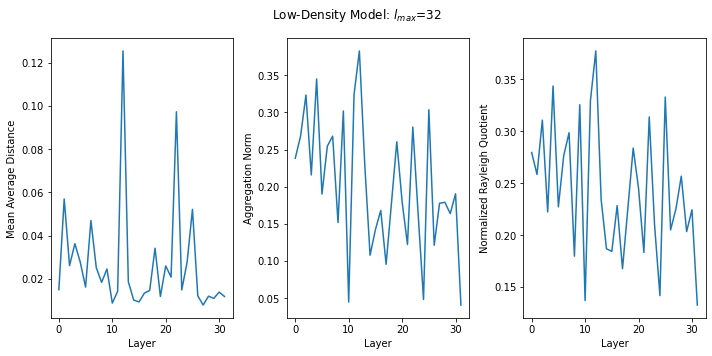

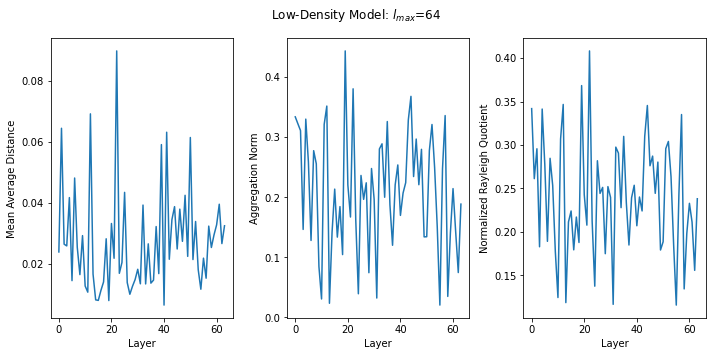

In [19]:
for idx,l in enumerate([4,8,16,32,64]):
  plt.figure(figsize=(10,5))

  plt.subplot(1,3,1)
  plt.plot(metrics[idx+2][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx+2][1])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx+2][2])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh Quotient')
    
  plt.suptitle("Low-Density Model: $l_{max}$="+str(l))
  plt.tight_layout()
  plt.show()


Our metrics for the low-density models exhibit an initial decline followed by growing oscillations as $l_{max}$ increases. Both GFS and MAD tend to worsen in the first few layers before beginning to decay. Like with the high-density case, the minimum values tend to be towards the end of the model. 

Each GCN is clearly attempting to drive $R$ down, yet is unable to achieve the same success as the high-density model. Even the deeper networks, which should be able to overcome the greater eigenvalue ratio, only do so much. In the next section, we investigate the role normalization may be playing in this and introduce a method to close the topology performance gap.